intro to project

First I'll need to import all of this project's dependencies as well as creating paths to the relevant source code and data directories within the repository

In [1]:
# creating paths to src and data folders in the repo
import sys
import pathlib
src_path = pathlib.Path().absolute().parent.parent / "src"
data_path = pathlib.Path().absolute().parent.parent / "data"
sys.path.append(str(src_path))

# source code functions for this project
import data_setup as ds
import modeling_functions as mf

# basic imports for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# import modeling packages
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# modeling metrics
from sklearn.metrics import classification_report, confusion_matrix

Now I'll need to create an instance of the pushshift psaw api. This api will allow me to search through all of reddit's content to retrieve the submissions required to build my dataset.

In [2]:
reddit = ds.get_api_instance(src_path)

Next I'll use this api to pull data from as many posts as I'd like. for this project I used a dataset of 6400 images, 3200 that were made using digital means, and 3200 made using other means. Only about 32% of posts made to r/Art are created using digital means, so my function fetch_balanced_submissions ensures that an equal number of posts is collected from each category to produce a balanced dataset.

In [3]:
table_of_contents = [ds.make_post_dict(post) for post in ds.fetch_balanced_submissions(6400, reddit, binary=True)]

(3200, 6400)
polling pushshift for 6400 more posts before 1606326383
polling pushshift for 6356 more posts before 1606319029
polling pushshift for 6326 more posts before 1606308398
polling pushshift for 6300 more posts before 1606295691
polling pushshift for 6272 more posts before 1606283492
polling pushshift for 6245 more posts before 1606271839
polling pushshift for 6227 more posts before 1606260872
polling pushshift for 6192 more posts before 1606251182
polling pushshift for 6166 more posts before 1606242009
polling pushshift for 6131 more posts before 1606233888
polling pushshift for 6091 more posts before 1606225600
polling pushshift for 6055 more posts before 1606214578
polling pushshift for 6024 more posts before 1606199193
polling pushshift for 5993 more posts before 1606185901
polling pushshift for 5956 more posts before 1606175509
polling pushshift for 5919 more posts before 1606166197
polling pushshift for 5891 more posts before 1606160377
polling pushshift for 5862 more pos

polling pushshift for 2086 more posts before 1604824961
polling pushshift for 2060 more posts before 1604810961
polling pushshift for 2036 more posts before 1604798075
polling pushshift for 2013 more posts before 1604787796
polling pushshift for 1995 more posts before 1604780414
polling pushshift for 1970 more posts before 1604772562
polling pushshift for 1938 more posts before 1604761300
polling pushshift for 1908 more posts before 1604750674
polling pushshift for 1884 more posts before 1604736841
polling pushshift for 1847 more posts before 1604719558
polling pushshift for 1815 more posts before 1604708734
polling pushshift for 1786 more posts before 1604699852
polling pushshift for 1755 more posts before 1604693764
polling pushshift for 1725 more posts before 1604687429
polling pushshift for 1698 more posts before 1604530652
polling pushshift for 1680 more posts before 1604520422
polling pushshift for 1645 more posts before 1604513439
polling pushshift for 1608 more posts before 160

I'm also writting the most critical meta-data to a json file so that it won't be lost when restarting the kernel

In [4]:
writeable_toc = [ds.make_post_dict_no_obj(post['post']) for post in table_of_contents]
toc_path = data_path / 'meta_data_final.json'
with open(toc_path, 'x') as f:
    f.write(json.dumps(writeable_toc))

In [4]:
# run this to load the json file into memory

# toc_path = data_path / 'meta_data_final.json'
# json_string = open(str(toc_path)).read()
# loaded_toc = json.loads(json_string)
# table_of_contents = loaded_toc

I'm taking a look at the distribution of medium types. Although it's only a binary classifiation there are still a total of 5 different medium classes (digital and non-digital which contains 4 classes: ink, non-ink-drawing, paint, sculpture)

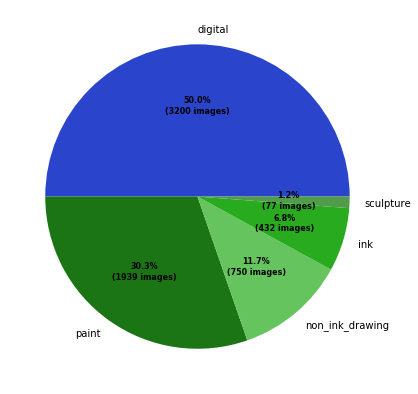

In [8]:
toc_df = pd.DataFrame(table_of_contents)

fig_path = pathlib.Path().absolute().parent.parent / "reports/figures"

colors = ("#2A45CC", "#1C7515","#65C45E",
          "#28AB1F", "#509C4B", "#2DC223") 

def get_percentages(pct, allvalues): 
    absolute = int(pct / 100.*sum(allvalues)) 
    return "{:.1f}%\n({:d} images)".format(pct, absolute) 
  
# Creating plot 
fig, ax = plt.subplots(figsize =(10, 7)) 
wedges, texts, autotexts = ax.pie(toc_df.medium.value_counts().values,  
                                  autopct = lambda pct: get_percentages(pct, list(toc_df.medium.value_counts().values)), 
                                  labels = toc_df.medium.value_counts().index,
                                  colors = colors,
                                  textprops = dict(color='black'),
                                  startangle = 0)
  
plt.setp(autotexts, size = 8, weight ="bold")
  
pie_path = fig_path / 'pie_distribution_final_black.png'
plt.savefig(pie_path, transparent=True)
plt.show()

For this project I used the flow-from-directory process to sequentially load batches of images to train on. This requires a specificlly formatted directory structure. establish_binary_directory creates the file structure required for flow-from-directory process within the specified file path.

Once the file structure is established, I can begin downloading the images for each post and storing them in their propper folders using download_and_store_binary. I used 3000 images per category for training, 100 per category for testing, and 100 per category for validation.

In [6]:
# create a directory structure to store sorted images with a train/test/validation split
ds.establish_binary_directory(data_path)

# download, sort, split, and store images from each post into the new file structure
# the filename for each image will be set using the format 'postid.jpg'
binary_data_path = data_path / 'binary_tts'
ds.download_and_store_binary(table_of_contents, binary_data_path, [3000, 100, 100])

downloading k0wvgl with 3199 remaining in digital
k0wvgl.jpg already exists
downloading k0wo64 with 3198 remaining in digital
k0wo64.jpg already exists
downloading k0wg41 with 3197 remaining in digital
k0wg41.jpg already exists
downloading k0w6y3 with 3196 remaining in digital
k0w6y3.jpg already exists
downloading k0w3j5 with 3195 remaining in digital
k0w3j5.jpg already exists
downloading k0vv0z with 3194 remaining in digital
k0vv0z.jpg already exists
downloading k0vpxs with 3193 remaining in digital
k0vpxs.jpg already exists
downloading k0vozh with 3192 remaining in digital
k0vozh.jpg already exists
downloading k0vo2o with 3191 remaining in digital
k0vo2o.jpg already exists
downloading k0ve3s with 3190 remaining in digital
k0ve3s.jpg already exists
downloading k0vaff with 3189 remaining in digital
k0vaff.jpg already exists
downloading k0v7p8 with 3188 remaining in digital
k0v7p8.jpg already exists
downloading k0v74m with 3187 remaining in digital
k0v74m.jpg already exists
downloading 

downloading jwnh9e with 2471 remaining in digital
jwnh9e.jpg already exists
downloading jwnaon with 2470 remaining in digital
jwnaon.jpg already exists
downloading jwmz5b with 2469 remaining in digital
jwmz5b.jpg already exists
downloading jwmymm with 2468 remaining in digital
jwmymm.jpg already exists
downloading jwmjhg with 2467 remaining in digital
jwmjhg.jpg already exists
downloading jwmi3z with 2466 remaining in digital
jwmi3z.jpg already exists
downloading jwmi3d with 2465 remaining in digital
jwmi3d.jpg already exists
downloading jwmeql with 2464 remaining in digital
jwmeql.jpg already exists
downloading jwm9km with 2463 remaining in digital
jwm9km.jpg already exists
downloading jwm5gk with 2462 remaining in digital
jwm5gk.jpg already exists
downloading jwlytp with 2461 remaining in digital
jwlytp.jpg already exists
downloading jwlyc0 with 2460 remaining in digital
jwlyc0.jpg already exists
downloading jwlvz6 with 2459 remaining in digital
jwlvz6.jpg already exists
downloading 

downloading jtz47a with 1973 remaining in digital
downloading jtyur6 with 1972 remaining in digital
downloading jtyjoz with 1971 remaining in digital
downloading jtyhem with 1970 remaining in digital
downloading jtyf5o with 1969 remaining in digital
downloading jty9zd with 1968 remaining in digital
downloading jty9vn with 1967 remaining in digital
downloading jty7xd with 1966 remaining in digital
downloading jtxvv6 with 1965 remaining in digital
downloading jtxuao with 1964 remaining in digital
downloading jtxtx0 with 1963 remaining in digital
downloading jtx9xg with 1962 remaining in digital
downloading jtx8ru with 1961 remaining in digital
downloading jtx0aj with 1960 remaining in digital
downloading jtwu8w with 1959 remaining in digital
downloading jtwn06 with 1958 remaining in digital
downloading jtw823 with 1957 remaining in digital
downloading jtw0hz with 1956 remaining in digital
downloading jtveyf with 1955 remaining in digital
downloading jtvahe with 1954 remaining in digital


downloading jt0p5d with 1808 remaining in digital
downloading jt0maj with 1807 remaining in digital
downloading jt0i3u with 1806 remaining in digital
downloading jsztfw with 1805 remaining in digital
downloading jszemt with 1804 remaining in digital
downloading jsyzke with 1803 remaining in digital
downloading jsyuga with 1802 remaining in digital
downloading jsyndb with 1801 remaining in digital
downloading jsyfx0 with 1800 remaining in digital
downloading jsye9v with 1799 remaining in digital
downloading jsycbv with 1798 remaining in digital
downloading jsy7bh with 1797 remaining in digital
downloading jsy2lv with 1796 remaining in digital
downloading jsy108 with 1795 remaining in digital
downloading jsy0o1 with 1794 remaining in digital
downloading jsxz23 with 1793 remaining in digital
downloading jsxxtu with 1792 remaining in digital
downloading jsxwcd with 1791 remaining in digital
downloading jsxiey with 1790 remaining in digital
downloading jsxfox with 1789 remaining in digital


downloading jiorj1 with 36 remaining in digital
downloading jiop20 with 35 remaining in digital
downloading jiolul with 34 remaining in digital
downloading jiol2m with 33 remaining in digital
downloading jioj77 with 32 remaining in digital
downloading jio6uh with 31 remaining in digital
downloading jio0a8 with 30 remaining in digital
downloading jinzct with 29 remaining in digital
downloading jinvj6 with 28 remaining in digital
downloading jingno with 27 remaining in digital
downloading jinceq with 26 remaining in digital
downloading jimr1h with 25 remaining in digital
downloading jimptd with 24 remaining in digital
downloading jimnas with 23 remaining in digital
downloading jimld4 with 22 remaining in digital
downloading jimfv6 with 21 remaining in digital
downloading jilnjy with 20 remaining in digital
downloading jikqnf with 19 remaining in digital
downloading jikh03 with 18 remaining in digital
downloading jikgmc with 17 remaining in digital
downloading jiketh with 16 remaining in 

downloading k0ba64 with 3079 remaining in non_digital
downloading k0b4ly with 3078 remaining in non_digital
downloading k0azbu with 3077 remaining in non_digital
downloading k0atcb with 3076 remaining in non_digital
downloading k0ar7y with 3075 remaining in non_digital
downloading k0ao2t with 3074 remaining in non_digital
downloading k0alyo with 3073 remaining in non_digital
downloading k0ahtn with 3072 remaining in non_digital
downloading k0ac1y with 3071 remaining in non_digital
downloading k0ab2q with 3070 remaining in non_digital
downloading k0a310 with 3069 remaining in non_digital
downloading k09r1u with 3068 remaining in non_digital
downloading k092o6 with 3067 remaining in non_digital
downloading k091rn with 3066 remaining in non_digital
downloading k08upc with 3065 remaining in non_digital
downloading k08sy6 with 3064 remaining in non_digital
downloading k08r86 with 3063 remaining in non_digital
downloading k08qkw with 3062 remaining in non_digital
downloading k08nn8 with 3061

downloading jznjvk with 2927 remaining in non_digital
downloading jznjn1 with 2926 remaining in non_digital
downloading jznhnr with 2925 remaining in non_digital
downloading jzndw1 with 2924 remaining in non_digital
downloading jzndsr with 2923 remaining in non_digital
downloading jzn9w7 with 2922 remaining in non_digital
downloading jzn6ri with 2921 remaining in non_digital
downloading jzn44m with 2920 remaining in non_digital
downloading jzmuvs with 2919 remaining in non_digital
downloading jzmsf5 with 2918 remaining in non_digital
downloading jzmnpv with 2917 remaining in non_digital
downloading jzmmys with 2916 remaining in non_digital
downloading jzmm7c with 2915 remaining in non_digital
downloading jzmetv with 2914 remaining in non_digital
downloading jzlwig with 2913 remaining in non_digital
downloading jzlsfx with 2912 remaining in non_digital
downloading jzlpi4 with 2911 remaining in non_digital
downloading jzln0a with 2910 remaining in non_digital
downloading jzlj1x with 2909

downloading jyycrp with 2775 remaining in non_digital
downloading jyy0n5 with 2774 remaining in non_digital
downloading jyxop0 with 2773 remaining in non_digital
downloading jyxmt0 with 2772 remaining in non_digital
downloading jyxkw3 with 2771 remaining in non_digital
downloading jyxgx7 with 2770 remaining in non_digital
downloading jyx655 with 2769 remaining in non_digital
downloading jyx3sf with 2768 remaining in non_digital
downloading jywz4a with 2767 remaining in non_digital
downloading jywco6 with 2766 remaining in non_digital
downloading jywa0p with 2765 remaining in non_digital
downloading jyw6mf with 2764 remaining in non_digital
downloading jyw6fe with 2763 remaining in non_digital
downloading jyw5zo with 2762 remaining in non_digital
downloading jyvxu3 with 2761 remaining in non_digital
downloading jyvvrn with 2760 remaining in non_digital
downloading jyvs6m with 2759 remaining in non_digital
downloading jyvkte with 2758 remaining in non_digital
downloading jyv7v8 with 2757

downloading jyfliw with 2623 remaining in non_digital
downloading jyfjlm with 2622 remaining in non_digital
downloading jyfji7 with 2621 remaining in non_digital
downloading jyfazv with 2620 remaining in non_digital
downloading jyf99g with 2619 remaining in non_digital
downloading jyf8ru with 2618 remaining in non_digital
downloading jyf21t with 2617 remaining in non_digital
downloading jyf1z6 with 2616 remaining in non_digital
downloading jyeq96 with 2615 remaining in non_digital
downloading jyeq1t with 2614 remaining in non_digital
downloading jyepkq with 2613 remaining in non_digital
downloading jyenuj with 2612 remaining in non_digital
downloading jyen3k with 2611 remaining in non_digital
downloading jyekwj with 2610 remaining in non_digital
downloading jyeg3p with 2609 remaining in non_digital
downloading jyee1k with 2608 remaining in non_digital
downloading jyecw6 with 2607 remaining in non_digital
downloading jye85x with 2606 remaining in non_digital
downloading jye5vg with 2605

downloading jxu1km with 2471 remaining in non_digital
downloading jxtrgz with 2470 remaining in non_digital
downloading jxtmp6 with 2469 remaining in non_digital
downloading jxtgkj with 2468 remaining in non_digital
downloading jxtg9p with 2467 remaining in non_digital
downloading jxtee4 with 2466 remaining in non_digital
downloading jxt7sm with 2465 remaining in non_digital
downloading jxt6fk with 2464 remaining in non_digital
downloading jxt249 with 2463 remaining in non_digital
downloading jxsxtk with 2462 remaining in non_digital
downloading jxssm0 with 2461 remaining in non_digital
downloading jxshq4 with 2460 remaining in non_digital
downloading jxseyf with 2459 remaining in non_digital
downloading jxsek8 with 2458 remaining in non_digital
downloading jxs6u9 with 2457 remaining in non_digital
downloading jxr2qe with 2456 remaining in non_digital
downloading jxqu20 with 2455 remaining in non_digital
downloading jxqlqx with 2454 remaining in non_digital
downloading jxqink with 2453

downloading jx5xsl with 2319 remaining in non_digital
downloading jx5x1q with 2318 remaining in non_digital
downloading jx5wxy with 2317 remaining in non_digital
downloading jx5tol with 2316 remaining in non_digital
downloading jx5ktt with 2315 remaining in non_digital
downloading jx5ist with 2314 remaining in non_digital
downloading jx5huk with 2313 remaining in non_digital
downloading jx5abv with 2312 remaining in non_digital
downloading jx57j7 with 2311 remaining in non_digital
downloading jx54z4 with 2310 remaining in non_digital
downloading jx4iiy with 2309 remaining in non_digital
downloading jx4hvo with 2308 remaining in non_digital
downloading jx4esx with 2307 remaining in non_digital
downloading jx48wy with 2306 remaining in non_digital
downloading jx43vq with 2305 remaining in non_digital
downloading jx3vri with 2304 remaining in non_digital
downloading jx3mg1 with 2303 remaining in non_digital
downloading jx3kdt with 2302 remaining in non_digital
downloading jx3jxd with 2301

downloading jwiaab with 2167 remaining in non_digital
downloading jwi9r7 with 2166 remaining in non_digital
downloading jwi4r5 with 2165 remaining in non_digital
downloading jwhwec with 2164 remaining in non_digital
downloading jwhoo9 with 2163 remaining in non_digital
downloading jwhia6 with 2162 remaining in non_digital
downloading jwh4ag with 2161 remaining in non_digital
downloading jwh2av with 2160 remaining in non_digital
downloading jwgzki with 2159 remaining in non_digital
downloading jwgy0t with 2158 remaining in non_digital
downloading jwgxlo with 2157 remaining in non_digital
downloading jwgtle with 2156 remaining in non_digital
downloading jwgrwx with 2155 remaining in non_digital
downloading jwgorv with 2154 remaining in non_digital
downloading jwgo1h with 2153 remaining in non_digital
downloading jwgnfp with 2152 remaining in non_digital
downloading jwgltv with 2151 remaining in non_digital
downloading jwgh02 with 2150 remaining in non_digital
downloading jwggdm with 2149

downloading jvvfas with 2015 remaining in non_digital
downloading jvverk with 2014 remaining in non_digital
downloading jvvdkt with 2013 remaining in non_digital
downloading jvv2bv with 2012 remaining in non_digital
downloading jvuyrj with 2011 remaining in non_digital
downloading jvuvyj with 2010 remaining in non_digital
downloading jvuvp5 with 2009 remaining in non_digital
downloading jvutky with 2008 remaining in non_digital
downloading jvut3h with 2007 remaining in non_digital
downloading jvuipk with 2006 remaining in non_digital
downloading jvu76k with 2005 remaining in non_digital
downloading jvu1lo with 2004 remaining in non_digital
downloading jvty6p with 2003 remaining in non_digital
downloading jvtxe7 with 2002 remaining in non_digital
downloading jvttt0 with 2001 remaining in non_digital
downloading jvtt6l with 2000 remaining in non_digital
downloading jvtppu with 1999 remaining in non_digital
downloading jvtm0t with 1998 remaining in non_digital
downloading jvtjiy with 1997

downloading jv89ul with 1863 remaining in non_digital
downloading jv7y4q with 1862 remaining in non_digital
downloading jv7r58 with 1861 remaining in non_digital
downloading jv7old with 1860 remaining in non_digital
downloading jv7mvo with 1859 remaining in non_digital
downloading jv7ezz with 1858 remaining in non_digital
downloading jv7au6 with 1857 remaining in non_digital
downloading jv79g0 with 1856 remaining in non_digital
downloading jv78cs with 1855 remaining in non_digital
downloading jv75rd with 1854 remaining in non_digital
downloading jv730v with 1853 remaining in non_digital
downloading jv71lp with 1852 remaining in non_digital
downloading jv70z6 with 1851 remaining in non_digital
downloading jv6jan with 1850 remaining in non_digital
downloading jv6ibx with 1849 remaining in non_digital
downloading jv6ev5 with 1848 remaining in non_digital
downloading jv6der with 1847 remaining in non_digital
downloading jv6b4q with 1846 remaining in non_digital
downloading jv5z9m with 1845

downloading jumbw2 with 1710 remaining in non_digital
downloading jumbue with 1709 remaining in non_digital
downloading jum7s6 with 1708 remaining in non_digital
downloading jum4sc with 1707 remaining in non_digital
downloading jum1fn with 1706 remaining in non_digital
downloading julw3a with 1705 remaining in non_digital
downloading jull7q with 1704 remaining in non_digital
downloading julej0 with 1703 remaining in non_digital
downloading julbxk with 1702 remaining in non_digital
downloading julba0 with 1701 remaining in non_digital
downloading julafb with 1700 remaining in non_digital
downloading jul8cj with 1699 remaining in non_digital
downloading juk84q with 1698 remaining in non_digital
downloading juk3pe with 1697 remaining in non_digital
downloading jujy6j with 1696 remaining in non_digital
downloading jujul9 with 1695 remaining in non_digital
downloading jujt7a with 1694 remaining in non_digital
downloading jujnop with 1693 remaining in non_digital
downloading jujbnb with 1692

downloading jtv6ot with 1558 remaining in non_digital
downloading jturz8 with 1557 remaining in non_digital
downloading jtu6ep with 1556 remaining in non_digital
downloading jttxhg with 1555 remaining in non_digital
downloading jttrci with 1554 remaining in non_digital
downloading jttk6w with 1553 remaining in non_digital
downloading jtti9y with 1552 remaining in non_digital
downloading jttd3u with 1551 remaining in non_digital
downloading jtt7b4 with 1550 remaining in non_digital
downloading jtt3f8 with 1549 remaining in non_digital
downloading jtsrrp with 1548 remaining in non_digital
downloading jtsesr with 1547 remaining in non_digital
downloading jtsbro with 1546 remaining in non_digital
downloading jtsasm with 1545 remaining in non_digital
downloading jts095 with 1544 remaining in non_digital
downloading jtrrqg with 1543 remaining in non_digital
downloading jtrrms with 1542 remaining in non_digital
downloading jtrqrj with 1541 remaining in non_digital
downloading jtrmm9 with 1540

downloading jt5eus with 1406 remaining in non_digital
downloading jt58g5 with 1405 remaining in non_digital
downloading jt4xr2 with 1404 remaining in non_digital
downloading jt4wdv with 1403 remaining in non_digital
downloading jt4mvy with 1402 remaining in non_digital
downloading jt4mb9 with 1401 remaining in non_digital
downloading jt4ijd with 1400 remaining in non_digital
downloading jt4d11 with 1399 remaining in non_digital
downloading jt460d with 1398 remaining in non_digital
downloading jt44qv with 1397 remaining in non_digital
downloading jt41yf with 1396 remaining in non_digital
downloading jt3zg7 with 1395 remaining in non_digital
downloading jt3x46 with 1394 remaining in non_digital
downloading jt3dxo with 1393 remaining in non_digital
downloading jt3949 with 1392 remaining in non_digital
downloading jt37cm with 1391 remaining in non_digital
downloading jt357o with 1390 remaining in non_digital
downloading jt2vgl with 1389 remaining in non_digital
downloading jt2sj7 with 1388

downloading jsdahh with 1254 remaining in non_digital
downloading jsd8if with 1253 remaining in non_digital
downloading jscvs0 with 1252 remaining in non_digital
downloading jsct2f with 1251 remaining in non_digital
downloading jscr1b with 1250 remaining in non_digital
downloading jsc4u8 with 1249 remaining in non_digital
downloading jsbjwo with 1248 remaining in non_digital
downloading jsbdoc with 1247 remaining in non_digital
downloading jsbctt with 1246 remaining in non_digital
downloading jsbbn0 with 1245 remaining in non_digital
downloading jsaqxs with 1244 remaining in non_digital
downloading jsamr1 with 1243 remaining in non_digital
downloading jsalr2 with 1242 remaining in non_digital
downloading jsaioa with 1241 remaining in non_digital
downloading js95ux with 1240 remaining in non_digital
downloading js93y6 with 1239 remaining in non_digital
downloading js8u9g with 1238 remaining in non_digital
downloading js8rfn with 1237 remaining in non_digital
downloading js8plg with 1236

downloading jrn9su with 1102 remaining in non_digital
downloading jrn3i4 with 1101 remaining in non_digital
downloading jrmzka with 1100 remaining in non_digital
downloading jrmzhd with 1099 remaining in non_digital
downloading jrmy5i with 1098 remaining in non_digital
downloading jrmemg with 1097 remaining in non_digital
downloading jrmdpw with 1096 remaining in non_digital
downloading jrm86q with 1095 remaining in non_digital
downloading jrm86i with 1094 remaining in non_digital
downloading jrm1aa with 1093 remaining in non_digital
downloading jrlyu0 with 1092 remaining in non_digital
downloading jrlnma with 1091 remaining in non_digital
downloading jrlhoz with 1090 remaining in non_digital
downloading jrlg0h with 1089 remaining in non_digital
downloading jrlbjz with 1088 remaining in non_digital
downloading jrl36w with 1087 remaining in non_digital
downloading jrkymy with 1086 remaining in non_digital
downloading jrkujr with 1085 remaining in non_digital
downloading jrk9ku with 1084

downloading jqzo2p with 949 remaining in non_digital
downloading jqzmjt with 948 remaining in non_digital
downloading jqzgys with 947 remaining in non_digital
downloading jqz98d with 946 remaining in non_digital
downloading jqz7f3 with 945 remaining in non_digital
downloading jqz58e with 944 remaining in non_digital
downloading jqywrc with 943 remaining in non_digital
downloading jqywc5 with 942 remaining in non_digital
downloading jqywa1 with 941 remaining in non_digital
downloading jqyfcr with 940 remaining in non_digital
downloading jqyf4n with 939 remaining in non_digital
downloading jqxwlj with 938 remaining in non_digital
downloading jqxuue with 937 remaining in non_digital
downloading jqxf3r with 936 remaining in non_digital
downloading jqxcex with 935 remaining in non_digital
downloading jqx7y6 with 934 remaining in non_digital
downloading jqwz98 with 933 remaining in non_digital
downloading jqwvbn with 932 remaining in non_digital
downloading jqw5dn with 931 remaining in non_d

downloading jq9r0g with 794 remaining in non_digital
downloading jq9nuu with 793 remaining in non_digital
downloading jq9i98 with 792 remaining in non_digital
downloading jq9hww with 791 remaining in non_digital
downloading jq9goe with 790 remaining in non_digital
downloading jq942c with 789 remaining in non_digital
downloading jq8xmj with 788 remaining in non_digital
downloading jq8t1h with 787 remaining in non_digital
downloading jq8p81 with 786 remaining in non_digital
downloading jq8lws with 785 remaining in non_digital
downloading jq8j3m with 784 remaining in non_digital
downloading jq7ys9 with 783 remaining in non_digital
downloading jq7twt with 782 remaining in non_digital
downloading jq7laf with 781 remaining in non_digital
downloading jq7dy1 with 780 remaining in non_digital
downloading jq767o with 779 remaining in non_digital
downloading jq75m1 with 778 remaining in non_digital
downloading jq6ua3 with 777 remaining in non_digital
downloading jq6of6 with 776 remaining in non_d

downloading jpe8h9 with 639 remaining in non_digital
downloading jpe6me with 638 remaining in non_digital
downloading jpe1li with 637 remaining in non_digital
downloading jpdwol with 636 remaining in non_digital
downloading jpdl0k with 635 remaining in non_digital
downloading jpdc8u with 634 remaining in non_digital
downloading jpdatd with 633 remaining in non_digital
downloading jpd5c0 with 632 remaining in non_digital
downloading jpd44a with 631 remaining in non_digital
downloading jpcv90 with 630 remaining in non_digital
downloading jpcudc with 629 remaining in non_digital
downloading jpcq33 with 628 remaining in non_digital
downloading jpcium with 627 remaining in non_digital
downloading jpccao with 626 remaining in non_digital
downloading jpc18v with 625 remaining in non_digital
downloading jpby0o with 624 remaining in non_digital
downloading jpbl35 with 623 remaining in non_digital
downloading jpbioe with 622 remaining in non_digital
downloading jpbilu with 621 remaining in non_d

downloading jnk7pi with 484 remaining in non_digital
downloading jnjwvf with 483 remaining in non_digital
downloading jnjvke with 482 remaining in non_digital
downloading jnjm56 with 481 remaining in non_digital
downloading jnjh0y with 480 remaining in non_digital
downloading jnjfdl with 479 remaining in non_digital
downloading jnjb3x with 478 remaining in non_digital
downloading jnisf0 with 477 remaining in non_digital
downloading jnicrv with 476 remaining in non_digital
downloading jniavu with 475 remaining in non_digital
downloading jniaqg with 474 remaining in non_digital
downloading jnia88 with 473 remaining in non_digital
downloading jni1ym with 472 remaining in non_digital
downloading jni0ie with 471 remaining in non_digital
downloading jnhym0 with 470 remaining in non_digital
downloading jnho55 with 469 remaining in non_digital
downloading jnhjyw with 468 remaining in non_digital
downloading jnhjb6 with 467 remaining in non_digital
downloading jnhgor with 466 remaining in non_d

downloading jmv71y with 329 remaining in non_digital
downloading jmv6t6 with 328 remaining in non_digital
downloading jmv566 with 327 remaining in non_digital
downloading jmv516 with 326 remaining in non_digital
downloading jmux2h with 325 remaining in non_digital
downloading jmuwzc with 324 remaining in non_digital
downloading jmun6m with 323 remaining in non_digital
downloading jmugob with 322 remaining in non_digital
downloading jmu4qa with 321 remaining in non_digital
downloading jmu09u with 320 remaining in non_digital
downloading jmtwa1 with 319 remaining in non_digital
downloading jmtqtl with 318 remaining in non_digital
downloading jmtqt5 with 317 remaining in non_digital
downloading jmtqcp with 316 remaining in non_digital
downloading jmti7t with 315 remaining in non_digital
downloading jmtf1p with 314 remaining in non_digital
downloading jmte4x with 313 remaining in non_digital
downloading jmtdsh with 312 remaining in non_digital
downloading jmt68s with 311 remaining in non_d

downloading jm223u with 174 remaining in non_digital
downloading jm14nl with 173 remaining in non_digital
downloading jm14i2 with 172 remaining in non_digital
downloading jm0vkw with 171 remaining in non_digital
downloading jm0uo3 with 170 remaining in non_digital
downloading jm0t5m with 169 remaining in non_digital
downloading jm0r3y with 168 remaining in non_digital
downloading jm0ojz with 167 remaining in non_digital
downloading jm0cn4 with 166 remaining in non_digital
downloading jm021o with 165 remaining in non_digital
downloading jlzreu with 164 remaining in non_digital
downloading jlzpuu with 163 remaining in non_digital
downloading jlzogk with 162 remaining in non_digital
downloading jlzj8t with 161 remaining in non_digital
downloading jlz1tc with 160 remaining in non_digital
downloading jlyema with 159 remaining in non_digital
downloading jly56a with 158 remaining in non_digital
downloading jlxuwt with 157 remaining in non_digital
downloading jlwg3g with 156 remaining in non_d

downloading jla0mp with 17 remaining in non_digital
downloading jl9r36 with 16 remaining in non_digital
downloading jl9h0k with 15 remaining in non_digital
downloading jl9fs8 with 14 remaining in non_digital
downloading jl93dn with 13 remaining in non_digital
downloading jl91fu with 12 remaining in non_digital
downloading jl8pqg with 11 remaining in non_digital
downloading jl8nm2 with 10 remaining in non_digital
downloading jl8eqf with 9 remaining in non_digital
downloading jl874q with 8 remaining in non_digital
downloading jl83q3 with 7 remaining in non_digital
downloading jl7tsj with 6 remaining in non_digital
downloading jl7ofy with 5 remaining in non_digital
downloading jl7dd1 with 4 remaining in non_digital
downloading jl7427 with 3 remaining in non_digital
downloading jl6s49 with 2 remaining in non_digital
downloading jl5qwg with 1 remaining in non_digital
downloading jl5k66 with 0 remaining in non_digital


Since I'm using the flow-from-directory process, before I can start modeling I need to create ImageDataGenerator objects using their flow_from_directory method. make_image_generators initializes these objects for each split with the proper parameters.

Next I'll compile a keras CNN model using my make_model function. make_model returns a compiled keras model with the arcitecture that gave me the best results during testing.

Finally I can train the model using the data generators I just created. I got my best results after about 6 epochs of training, so I'll use 6 epochs again here.

In [ ]:
train_generator, test_generator, val_generator = mf.make_image_generators(binary_data_path)

model = mf.make_model()

model.fit(train_generator,
          steps_per_epoch=300,
          epochs=6,
          validation_data=val_generator,
          validation_steps=10)

First I'll analyze the confusion matrix for the validation data I used during model developement

In [ ]:
# validation matrix

conf_mat = confusion_matrix(val_generator.classes, model.predict_classes(val_generator))

class_names = list(val_generator.class_indices.keys())

fig, ax = plt.subplots(figsize=(8,6))
final_model_validation_path = pathlib.Path().absolute().parent.parent / 'reports/figures/final_validation_heatmap.png'
ax.set_ylim([0,1])
sns.heatmap(conf_mat, xticklabels=class_names, yticklabels=class_names, ax=ax, square=True, annot=True, cmap='Blues')
plt.savefig(final_model_validation_path)

Next I'll check to see if the final testing data follows the same trend

In [ ]:
# testing matrix
conf_mat = confusion_matrix(test_generator.classes, model.predict_classes(test_generator))

class_names = list(test_generator.class_indices.keys())

fig, ax = plt.subplots(figsize=(8,6))
final_model_test_path = pathlib.Path().absolute().parent.parent / 'reports/figures/final_test_heatmap.png'
ax.set_ylim([0,1])
sns.heatmap(conf_mat, xticklabels=class_names, yticklabels=class_names, ax=ax, square=True, annot=True, cmap='Blues')
plt.savefig(final_model_test_path)

more evaluation, potential improvements